# Customer Segmentation Using Clustering


**People:**

* ID: Customer's unique identifier
* Year_Birth: Customer's birth year
* Education: Customer's education level
* Marital_Status: Customer's marital status
* Income: Customer's yearly household income
* Kidhome: Number of children in customer's household
* Teenhome`: Number of teenagers in customer's household
* Dt_Customer: Date of customer's enrollment with the company
* Recency: Number of days since customer's last purchase
* Complain: 1 if the customer complained in the last 2 years, 0 otherwise

**Products:**

* MntFruits: Amount spent on fruits in last 2 years
* MntMeatProducts: Amount spent on meat in last 2 years
* MntFishProducts: Amount spent on fish in last 2 years
* MntSweetProducts: Amount spent on sweets in last 2 years
* MntGoldProds: Amount spent on gold in last 2 years
* MntWines: Amount spent on wine in last 2 years

**Promotion:**

* NumDealsPurchases`: Number of purchases made with a discount
* AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
* AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
* AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
* AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
* AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
* Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

**Place:**

* NumWebPurchases: Number of purchases made through the company’s website
* NumCatalogPurchases: Number of purchases made using a catalogue
* NumStorePurchases: Number of purchases made directly in stores
* NumWebVisitsMonth: Number of visits to company’s website in the last month

Libraries

In [1]:
# handle table-like data and matrices
import pandas as pd
import numpy as np

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# preprocessing
from sklearn.preprocessing import StandardScaler

# pca
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import linkage, fcluster
# clustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering

# evaluations
from sklearn.metrics import confusion_matrix

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# to display the total number columns present in the dataset
pd.set_option('display.max_columns', None)

read data

In [2]:
data = pd.read_csv('marketing_campaign.csv', sep="\t")

Handling missing values

In [3]:
# Handling missing values
data.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [4]:
data = data.dropna()

In [5]:
data.isnull().sum()

ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
dtype: int64

In [6]:
# check duplicate rows

data.duplicated().sum()

0

In [7]:
# info
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2216 non-null   int64  
 1   Year_Birth           2216 non-null   int64  
 2   Education            2216 non-null   object 
 3   Marital_Status       2216 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2216 non-null   int64  
 6   Teenhome             2216 non-null   int64  
 7   Dt_Customer          2216 non-null   object 
 8   Recency              2216 non-null   int64  
 9   MntWines             2216 non-null   int64  
 10  MntFruits            2216 non-null   int64  
 11  MntMeatProducts      2216 non-null   int64  
 12  MntFishProducts      2216 non-null   int64  
 13  MntSweetProducts     2216 non-null   int64  
 14  MntGoldProds         2216 non-null   int64  
 15  NumDealsPurchases    2216 non-null   i

Dt_Customer that indicates the date a customer joined the database is not parsed as DateTime

In [8]:
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])


In [9]:
print("The newest customer's enrolment date in the records:", max(data['Dt_Customer']))
print("The oldest customer's enrolment date in the records:", min(data['Dt_Customer']))

The newest customer's enrolment date in the records: 2014-12-06 00:00:00
The oldest customer's enrolment date in the records: 2012-01-08 00:00:00


Extract the "Age" of a customer by the "Year_Birth" indicating the birth year of the respective person.

In [10]:
data['Age'] = 2015 - data['Year_Birth']

Create another feature "Spent" indicating the total amount spent by the customer in various categories over the span of two years.

In [11]:
data['Spent'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']

Create another feature "Living_With" out of "Marital_Status" to extract the living situation of couples.

In [12]:
data['Living_With'] = data['Marital_Status'].replace({'Married':'Partner', 'Together':'Partner', 'Absurd':'Alone', 'Widow':'Alone', 'YOLO':'Alone', 'Divorced':'Alone', 'Single':'Alone'})

Create a feature "Children" to indicate total children in a household that is, kids and teenagers.

In [13]:
data['Children'] = data['Kidhome'] + data['Teenhome']

To get further clarity of household, Creating feature indicating "Family_Size"

In [ ]:
data['Family_Size'] = data['Living_With'].replace({'Alone': 1, 'Partner':2}) + data['Children']

Create a feature "Is_Parent" to indicate parenthood status

In [15]:
data['Is_Parent'] = np.where(data.Children > 0, 1, 0)

Segmenting education levels in three groups

In [16]:
data['Education'] = data['Education'].replace({'Basic':'Undergraduate', '2n Cycle':'Undergraduate', 'Graduation':'Graduate', 'Master':'Postgraduate', 'PhD':'Postgraduate'})

Dropping some of the redundant features

In [17]:
to_drop = ['Marital_Status', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue', 'Year_Birth', 'ID']
data = data.drop(to_drop, axis=1)

In [18]:
data.head(3)

Education   Income  Kidhome  Teenhome  Recency  MntWines  MntFruits  \
0  Graduate  58138.0        0         0       58       635         88   
1  Graduate  46344.0        1         1       38        11          1   
2  Graduate  71613.0        0         0       26       426         49   

   MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  \
0              546              172                88            88   
1                6                2                 1             6   
2              127              111                21            42   

   NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
0                  3                8                   10                  4   
1                  2                1                    1                  2   
2                  1                8                    2                 10   

   NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  \
0                  7             0             0             0             0   
1                  5             0             0             0             0   
2                  4             0             0             0             0   

   AcceptedCmp2  Complain  Response  Age  Spent Living_With  Children  \
0             0         0         1   58   1617       Alone         0   
1             0         0         0   61     27       Alone         2   
2             0         0         0   50    776     Partner         0   

   Family_Size  Is_Parent  
0            1          0  
1            3          1  
2            2          0

In [19]:
data.shape

(2216, 29)

There are 2216 cutomers and 29 features in the dataset.

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2216 non-null   object 
 1   Income               2216 non-null   float64
 2   Kidhome              2216 non-null   int64  
 3   Teenhome             2216 non-null   int64  
 4   Recency              2216 non-null   int64  
 5   MntWines             2216 non-null   int64  
 6   MntFruits            2216 non-null   int64  
 7   MntMeatProducts      2216 non-null   int64  
 8   MntFishProducts      2216 non-null   int64  
 9   MntSweetProducts     2216 non-null   int64  
 10  MntGoldProds         2216 non-null   int64  
 11  NumDealsPurchases    2216 non-null   int64  
 12  NumWebPurchases      2216 non-null   int64  
 13  NumCatalogPurchases  2216 non-null   int64  
 14  NumStorePurchases    2216 non-null   int64  
 15  NumWebVisitsMonth    2216 non-null   i

In [21]:
data.describe()

Income      Kidhome     Teenhome      Recency     MntWines  \
count    2216.000000  2216.000000  2216.000000  2216.000000  2216.000000   
mean    52247.251354     0.441787     0.505415    49.012635   305.091606   
std     25173.076661     0.536896     0.544181    28.948352   337.327920   
min      1730.000000     0.000000     0.000000     0.000000     0.000000   
25%     35303.000000     0.000000     0.000000    24.000000    24.000000   
50%     51381.500000     0.000000     0.000000    49.000000   174.500000   
75%     68522.000000     1.000000     1.000000    74.000000   505.000000   
max    666666.000000     2.000000     2.000000    99.000000  1493.000000   

         MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  \
count  2216.000000      2216.000000      2216.000000       2216.000000   
mean     26.356047       166.995939        37.637635         27.028881   
std      39.793917       224.283273        54.752082         41.072046   
min       0.000000         0.000000         0.000000          0.000000   
25%       2.000000        16.000000         3.000000          1.000000   
50%       8.000000        68.000000        12.000000          8.000000   
75%      33.000000       232.250000        50.000000         33.000000   
max     199.000000      1725.000000       259.000000        262.000000   

       MntGoldProds  NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
count   2216.000000        2216.000000      2216.000000          2216.000000   
mean      43.965253           2.323556         4.085289             2.671029   
std       51.815414           1.923716         2.740951             2.926734   
min        0.000000           0.000000         0.000000             0.000000   
25%        9.000000           1.000000         2.000000             0.000000   
50%       24.500000           2.000000         4.000000             2.000000   
75%       56.000000           3.000000         6.000000             4.000000   
max      321.000000          15.000000        27.000000            28.000000   

       NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  \
count        2216.000000        2216.000000   2216.000000   2216.000000   
mean            5.800993           5.319043      0.073556      0.074007   
std             3.250785           2.425359      0.261106      0.261842   
min             0.000000           0.000000      0.000000      0.000000   
25%             3.000000           3.000000      0.000000      0.000000   
50%             5.000000           6.000000      0.000000      0.000000   
75%             8.000000           7.000000      0.000000      0.000000   
max            13.000000          20.000000      1.000000      1.000000   

       AcceptedCmp5  AcceptedCmp1  AcceptedCmp2     Complain     Response  \
count   2216.000000   2216.000000   2216.000000  2216.000000  2216.000000   
mean       0.073105      0.064079      0.013538     0.009477     0.150271   
std        0.260367      0.244950      0.115588     0.096907     0.357417   
min        0.000000      0.000000      0.000000     0.000000     0.000000   
25%        0.000000      0.000000      0.000000     0.000000     0.000000   
50%        0.000000      0.000000      0.000000     0.000000     0.000000   
75%        0.000000      0.000000      0.000000     0.000000     0.000000   
max        1.000000      1.000000      1.000000     1.000000     1.000000   

               Age        Spent     Children  Family_Size    Is_Parent  
count  2216.000000  2216.000000  2216.000000  2216.000000  2216.000000  
mean     46.179603   607.075361     0.947202     2.592509     0.714350  
std      11.985554   602.900476     0.749062     0.905722     0.451825  
min      19.000000     5.000000     0.000000     1.000000     0.000000  
25%      38.000000    69.000000     0.000000     2.000000     0.000000  
50%      45.000000   396.500000     1.000000     3.000000     1.000000  
75%      56.000000  1048.000000     1.000000     3.000000   

In [22]:
data.describe(include=object).T

count unique       top  freq
Education    2216      3  Graduate  1116
Living_With  2216      2   Partner  1430

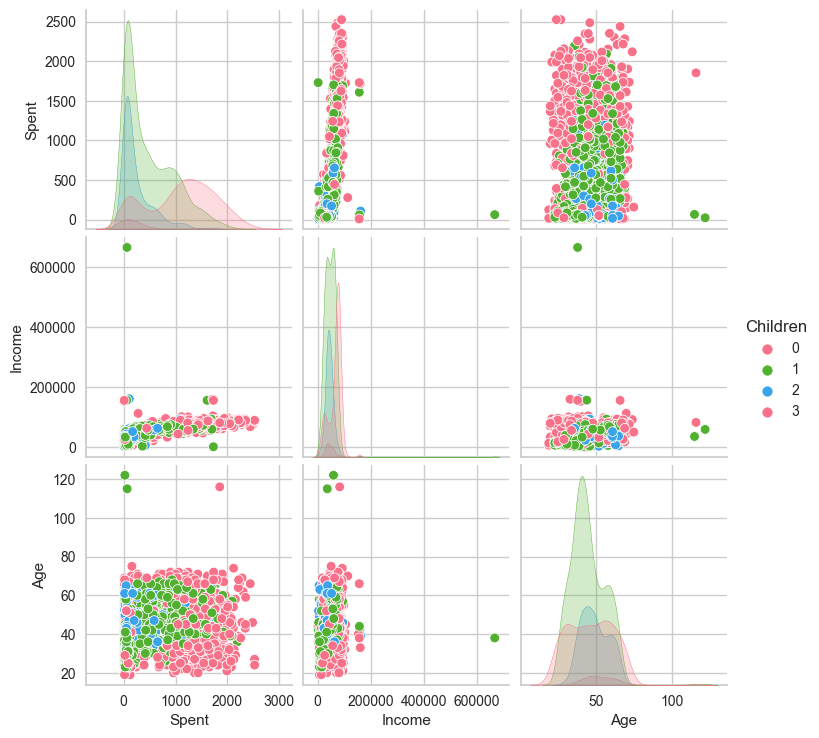

In [23]:
sns.pairplot(data , vars=['Spent','Income','Age'] , hue='Children', palette='husl');

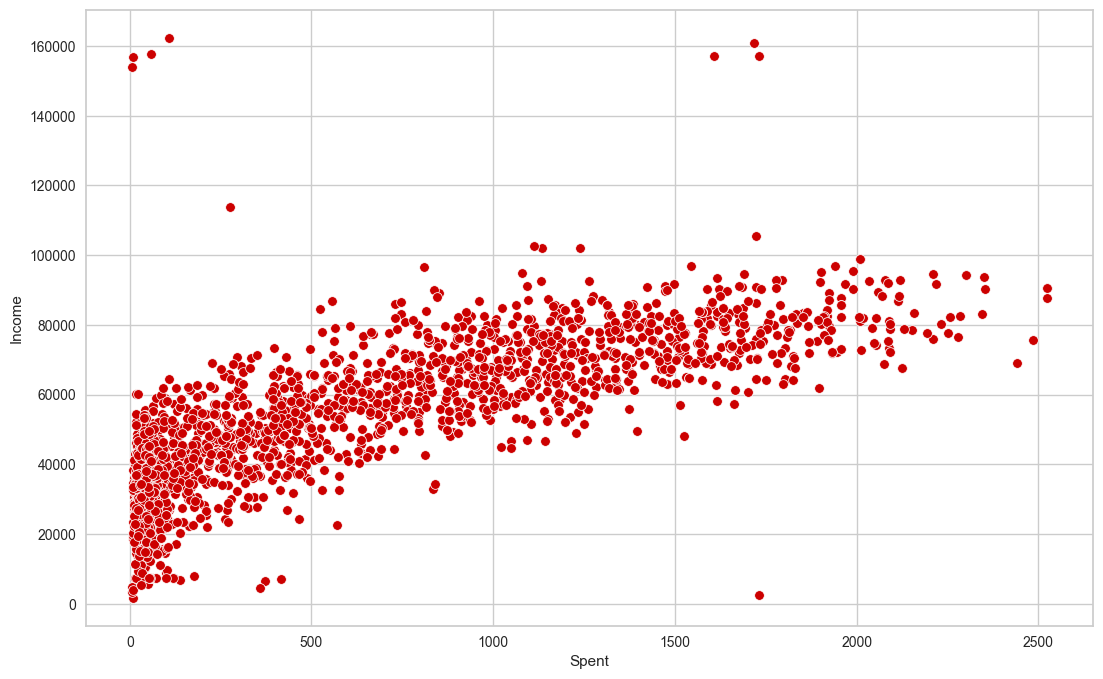

In [24]:
plt.figure(figsize=(13,8))
sns.scatterplot(x=data[data['Income']<600000]['Spent'], y=data[data['Income']<600000]['Income'], color='#cc0000');

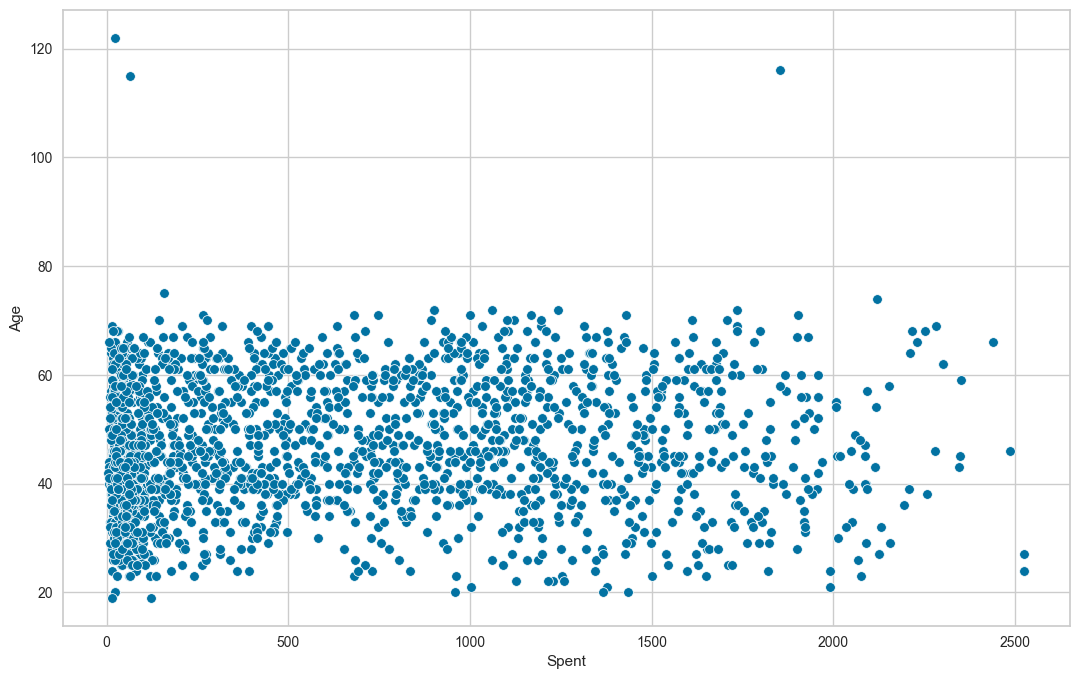

In [25]:
plt.figure(figsize=(13,8))
sns.scatterplot(x=data['Spent'], y=data['Age']);

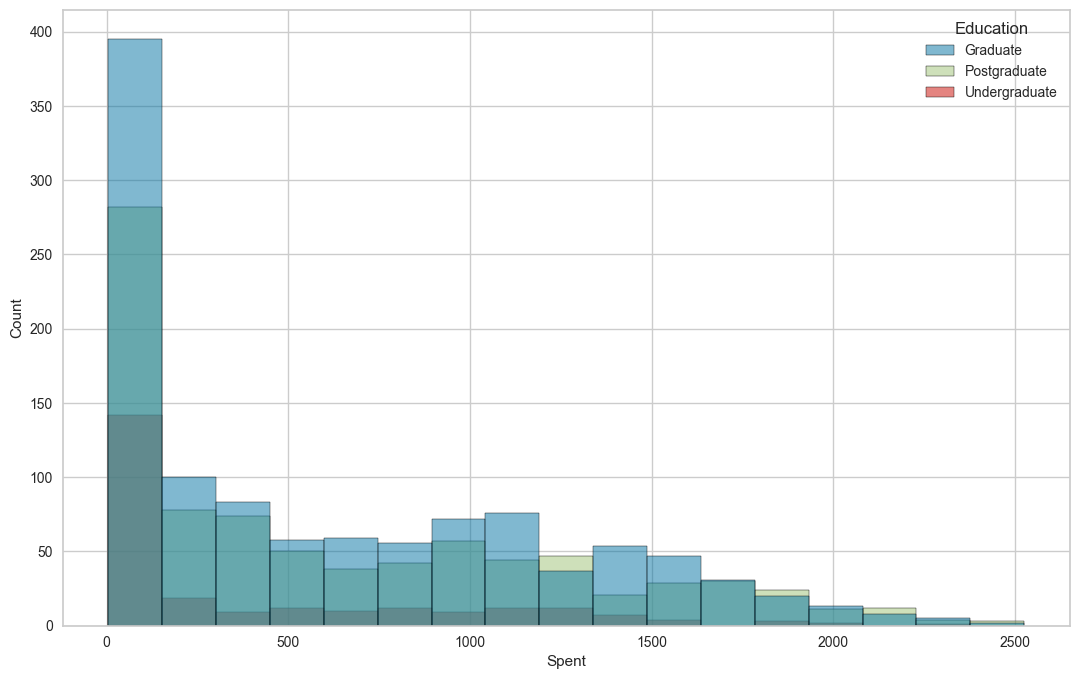

In [26]:
plt.figure(figsize=(13,8))
sns.histplot(x=data['Spent'], hue=data['Education']);

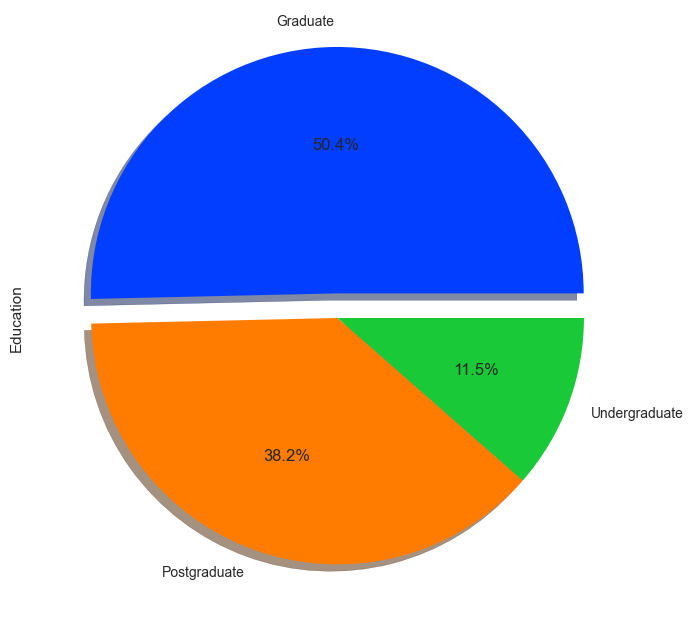

In [27]:
data['Education'].value_counts().plot.pie(explode=[0.1,0,0], autopct='%1.1f%%', shadow=True, figsize=(8,8), colors=sns.color_palette('bright'));

Detecting Outliers

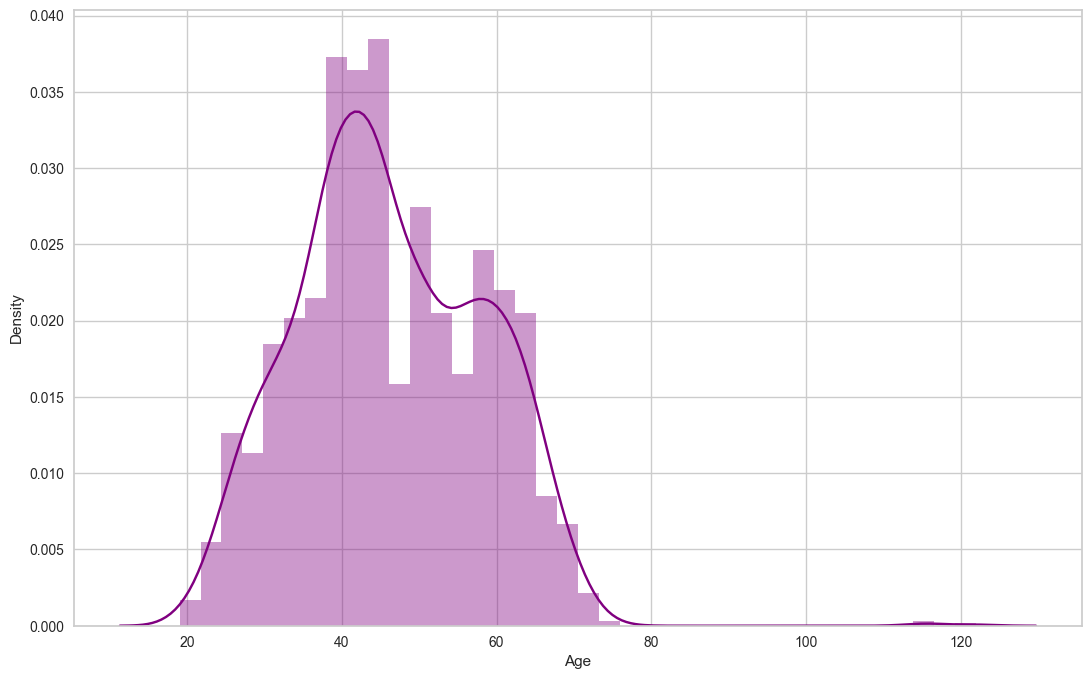

In [28]:
plt.figure(figsize=(13,8))
sns.distplot(data.Age, color='purple');

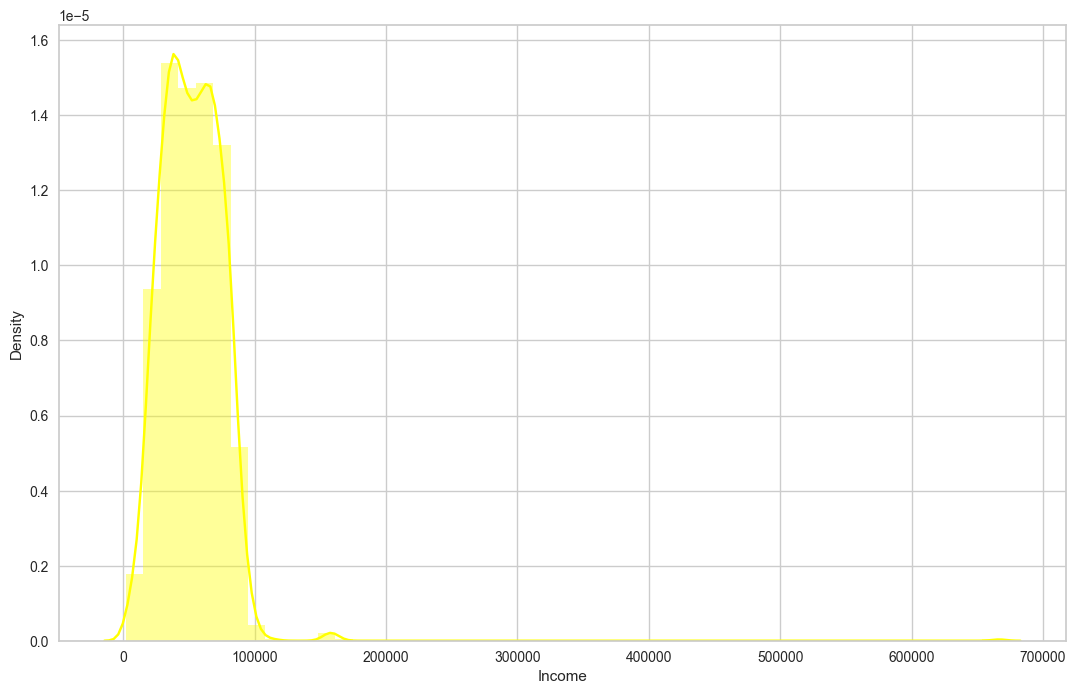

In [29]:
plt.figure(figsize=(13,8))
sns.distplot(data.Income, color='Yellow');

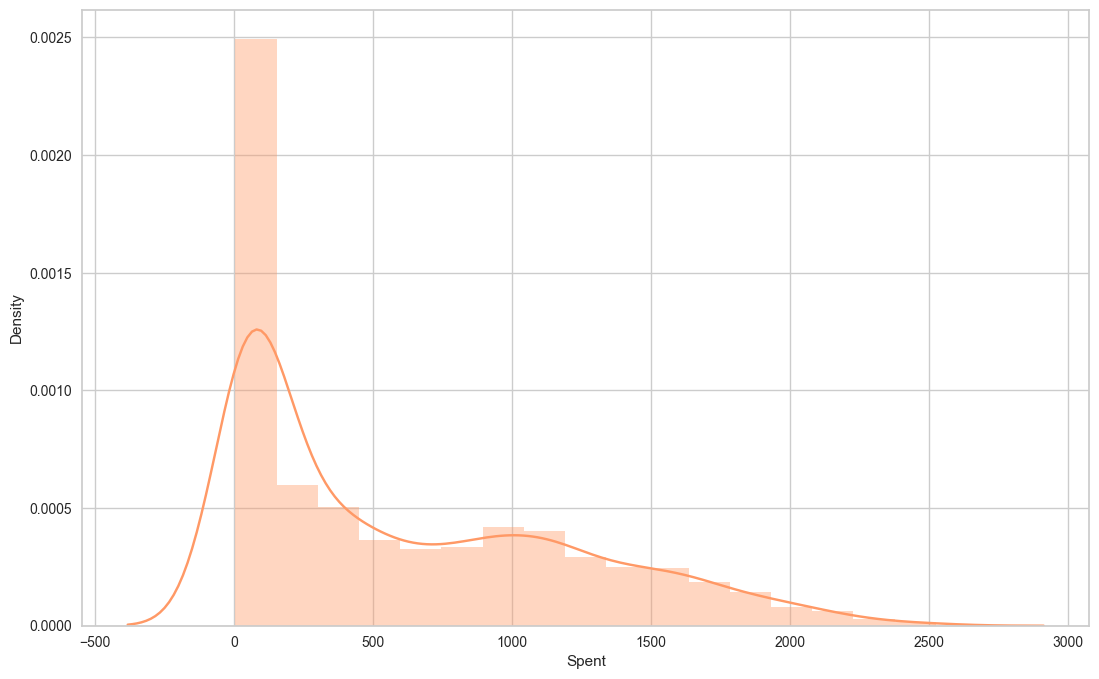

In [30]:
plt.figure(figsize=(13,8))
sns.distplot(data.Spent, color='#ff9966');

In [31]:
numerical = ['Income', 'Recency', 'Age', 'Spent']

In [32]:
def detect_outliers(d):
  for i in d:
    Q3, Q1 = np.percentile(data[i], [75 ,25])
    IQR = Q3 - Q1

    ul = Q3+1.5*IQR
    ll = Q1-1.5*IQR

    outliers = data[i][(data[i] > ul) | (data[i] < ll)]
    print(f'*** {i} outlier points***', '\n', outliers, '\n')

In [33]:
detect_outliers(numerical)

*** Income outlier points*** 
 164     157243.0
617     162397.0
655     153924.0
687     160803.0
1300    157733.0
1653    157146.0
2132    156924.0
2233    666666.0
Name: Income, dtype: float64 

*** Recency outlier points*** 
 Series([], Name: Recency, dtype: int64) 

*** Age outlier points*** 
 192    115
239    122
339    116
Name: Age, dtype: int64 

*** Spent outlier points*** 
 1179    2525
1492    2524
1572    2525
Name: Spent, dtype: int64 



Remove Outliers

In [34]:
data = data[(data['Age']<100)]
data = data[(data['Income']<600000)]

In [35]:
data.shape

(2212, 29)

Categorical Coulmns

In [36]:
categorical = [var for var in data.columns if data[var].dtype=='O']

In [ ]:
# check the number of different labels
for var in categorical:
    print(data[var].value_counts() / np.float(len(data)))
    print()
    print()

Graduate         0.504069
Postgraduate     0.382007
Undergraduate    0.113924
Name: Education, dtype: float64


Partner    0.64557
Alone      0.35443
Name: Living_With, dtype: float64




In [38]:
data['Education'] = data['Education'].map({'Undergraduate':0,'Graduate':1, 'Postgraduate':2})

In [39]:
data['Living_With'] = data['Living_With'].map({'Alone':0,'Partner':1})

In [40]:
data.dtypes

Education                int64
Income                 float64
Kidhome                  int64
Teenhome                 int64
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Response                 int64
Age                      int64
Spent                    int64
Living_With              int64
Children                 int64
Family_Size              int64
Is_Parent                int32
dtype: object

In [41]:
data.head(3)

Education   Income  Kidhome  Teenhome  Recency  MntWines  MntFruits  \
0          1  58138.0        0         0       58       635         88   
1          1  46344.0        1         1       38        11          1   
2          1  71613.0        0         0       26       426         49   

   MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  \
0              546              172                88            88   
1                6                2                 1             6   
2              127              111                21            42   

   NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
0                  3                8                   10                  4   
1                  2                1                    1                  2   
2                  1                8                    2                 10   

   NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  \
0                  7             0             0             0             0   
1                  5             0             0             0             0   
2                  4             0             0             0             0   

   AcceptedCmp2  Complain  Response  Age  Spent  Living_With  Children  \
0             0         0         1   58   1617            0         0   
1             0         0         0   61     27            0         2   
2             0         0         0   50    776            1         0   

   Family_Size  Is_Parent  
0            1          0  
1            3          1  
2            2          0

<AxesSubplot: >

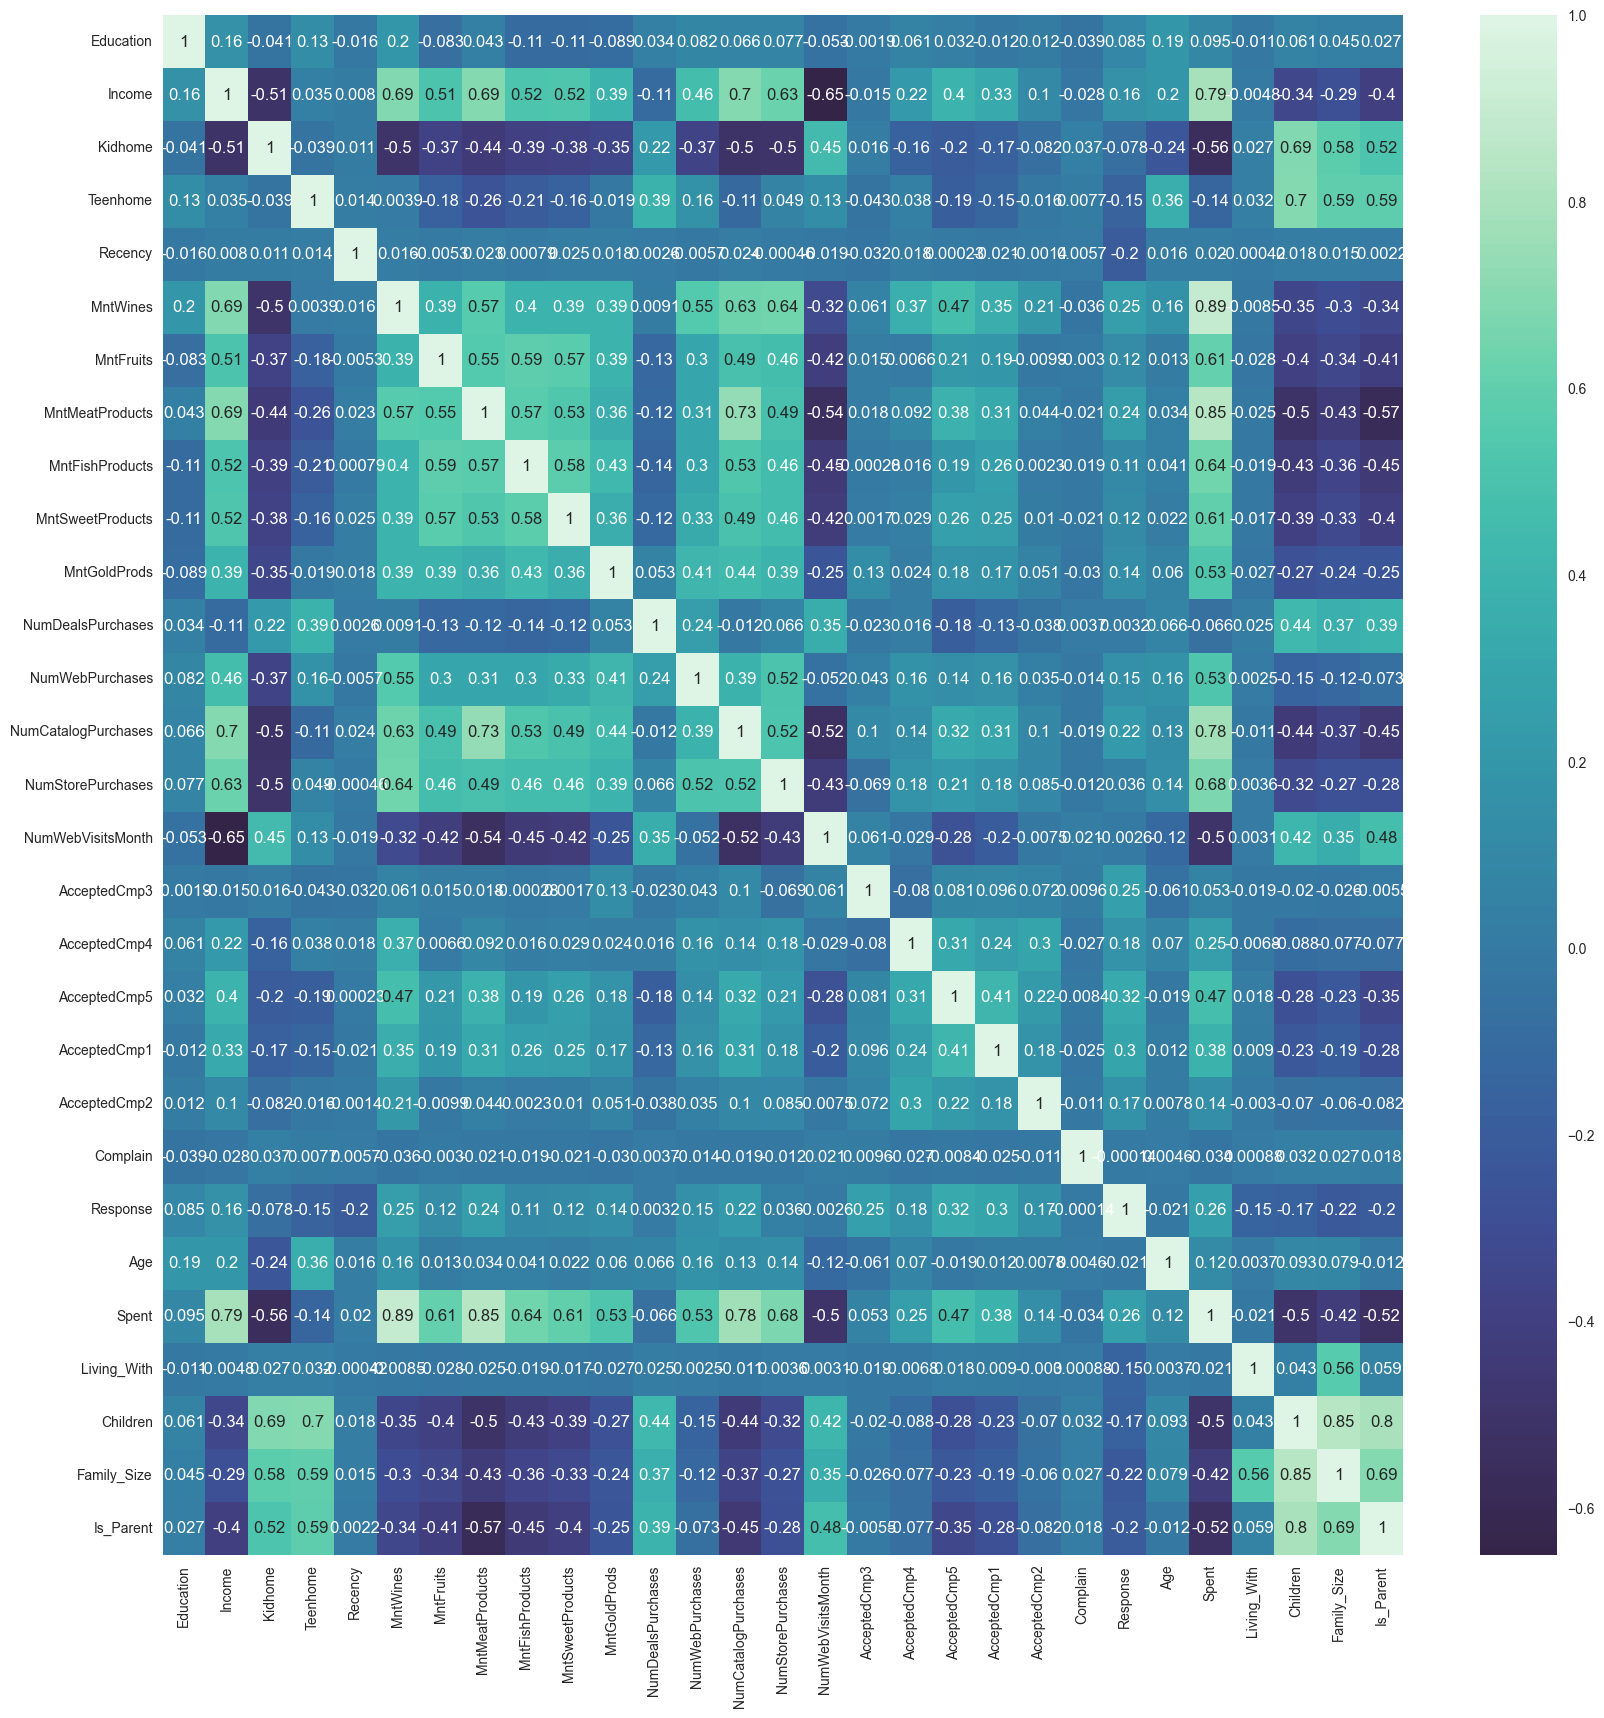

In [42]:
corrmat = data.corr()

plt.figure(figsize=(20,20))  
sns.heatmap(corrmat, annot = True, cmap = 'mako', center = 0)

In [43]:
data_old = data.copy()

In [44]:
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
data = data.drop(cols_del, axis=1)

Feature Scaling

In [45]:
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)

In [46]:
data.head(3)

Education    Income   Kidhome  Teenhome   Recency  MntWines  MntFruits  \
0  -0.411675  0.287105 -0.822754 -0.929699  0.310353  0.977660   1.552041   
1  -0.411675 -0.260882  1.040021  0.908097 -0.380813 -0.872618  -0.637461   
2  -0.411675  0.913196 -0.822754 -0.929699 -0.795514  0.357935   0.570540   

   MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  \
0         1.690293         2.453472          1.483713      0.852576   
1        -0.718230        -0.651004         -0.634019     -0.733642   
2        -0.178542         1.339513         -0.147184     -0.037254   

   NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
0           0.351030         1.426865             2.503607          -0.555814   
1          -0.168701        -1.126420            -0.571340          -1.171160   
2          -0.688432         1.426865            -0.229679           1.290224   

   NumWebVisitsMonth       Age     Spent  Living_With  Children  Family_Size  \
0           0.692181  1.018352  1.676245    -1.349603 -1.264598    -1.758359   
1          -0.132545  1.274785 -0.963297    -1.349603  1.404572     0.449070   
2          -0.544908  0.334530  0.280110     0.740959 -1.264598    -0.654644   

   Is_Parent  
0  -1.581139  
1   0.632456  
2  -1.581139

Dimensionality_Reduction

In [47]:
p = PCA(n_components=3)
p.fit(data)

PCA(n_components=3)

In [48]:
W = p.components_.T
W

array([[ 1.13472974e-02,  1.40726199e-01, -5.06868139e-01],
       [ 2.79487049e-01,  1.78234578e-01, -7.52771001e-02],
       [-2.46222761e-01,  5.22701463e-03,  2.82771962e-01],
       [-9.87087875e-02,  4.62105836e-01, -1.51581307e-01],
       [ 3.52657243e-03,  1.62577297e-02,  3.59482858e-02],
       [ 2.55717112e-01,  2.09384025e-01, -1.17038623e-01],
       [ 2.38397826e-01,  1.10523765e-02,  2.54539173e-01],
       [ 2.85462056e-01,  9.91828180e-03,  7.64487707e-02],
       [ 2.48709927e-01,  2.42875546e-04,  2.53486808e-01],
       [ 2.37301759e-01,  2.16444101e-02,  2.57599576e-01],
       [ 1.88380367e-01,  1.23091517e-01,  1.99325446e-01],
       [-7.82601140e-02,  3.48734637e-01,  1.52440840e-01],
       [ 1.67559733e-01,  2.96779094e-01,  2.33735791e-02],
       [ 2.77349140e-01,  1.05955912e-01,  1.76399754e-02],
       [ 2.41542892e-01,  2.05478054e-01, -8.11245926e-03],
       [-2.25949406e-01,  4.61019702e-02,  9.09303027e-02],
       [ 3.84647081e-02,  2.34782218e-01

In [49]:
pd.DataFrame(W, index=data.columns, columns=['W1','W2','W3'])

W1        W2        W3
Education            0.011347  0.140726 -0.506868
Income               0.279487  0.178235 -0.075277
Kidhome             -0.246223  0.005227  0.282772
Teenhome            -0.098709  0.462106 -0.151581
Recency              0.003527  0.016258  0.035948
MntWines             0.255717  0.209384 -0.117039
MntFruits            0.238398  0.011052  0.254539
MntMeatProducts      0.285462  0.009918  0.076449
MntFishProducts      0.248710  0.000243  0.253487
MntSweetProducts     0.237302  0.021644  0.257600
MntGoldProds         0.188380  0.123092  0.199325
NumDealsPurchases   -0.078260  0.348735  0.152441
NumWebPurchases      0.167560  0.296779  0.023374
NumCatalogPurchases  0.277349  0.105956  0.017640
NumStorePurchases    0.241543  0.205478 -0.008112
NumWebVisitsMonth   -0.225949  0.046102  0.090930
Age                  0.038465  0.234782 -0.428758
Spent                0.320099  0.133708  0.037437
Living_With         -0.027576  0.125509  0.300437
Children            -0.248087  0.339321  0.092515
Family_Size         -0.219730  0.346884  0.235127
Is_Parent           -0.242808  0.292277  0.082107

In [50]:
p.explained_variance_

array([8.27465625, 2.9209145 , 1.43060041])

In [51]:
p.explained_variance_ratio_

array([0.3759507 , 0.13270882, 0.06499789])

In [52]:
pd.DataFrame(p.explained_variance_ratio_, index=range(1,4), columns=['Explained Variability'])

Explained Variability
1               0.375951
2               0.132709
3               0.064998

In [53]:
p.explained_variance_ratio_.cumsum()

array([0.3759507 , 0.50865952, 0.57365741])

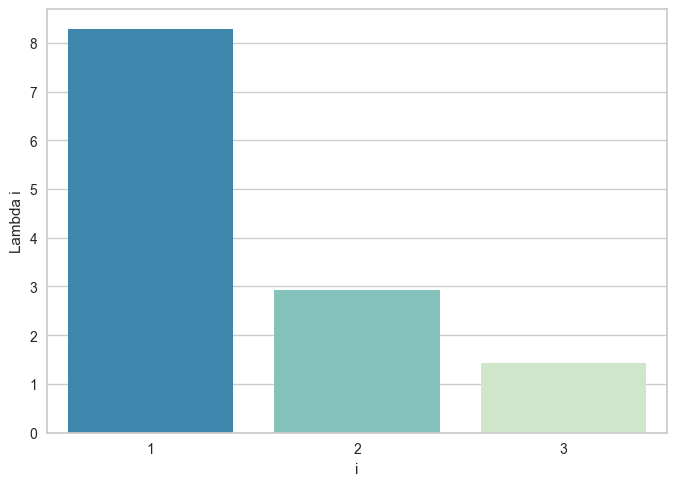

In [54]:
sns.barplot(x = list(range(1,4)), y = p.explained_variance_, palette = 'GnBu_r')
plt.xlabel('i')
plt.ylabel('Lambda i');

In [55]:
data_PCA = pd.DataFrame(p.transform(data), columns=(['col1', 'col2', 'col3']))


In [56]:
data_PCA.head()

col1      col2      col3
0  4.908732 -0.537851  0.449277
1 -2.865084  0.131295 -0.983883
2  2.597497 -0.780279 -0.043248
3 -2.650425 -1.456923  1.059099
4 -0.600206  0.438487  0.989088

In [57]:
data_PCA.describe().T

count          mean       std       min       25%       50%       75%  \
col1  2212.0  9.636656e-17  2.876570 -5.915030 -2.548037 -0.784932  2.418554   
col2  2212.0 -1.927331e-17  1.709068 -4.398451 -1.343423 -0.133324  1.243055   
col3  2212.0  1.284887e-17  1.196079 -3.542777 -0.864779 -0.015244  0.823347   

           max  
col1  7.441146  
col2  6.248172  
col3  5.032477

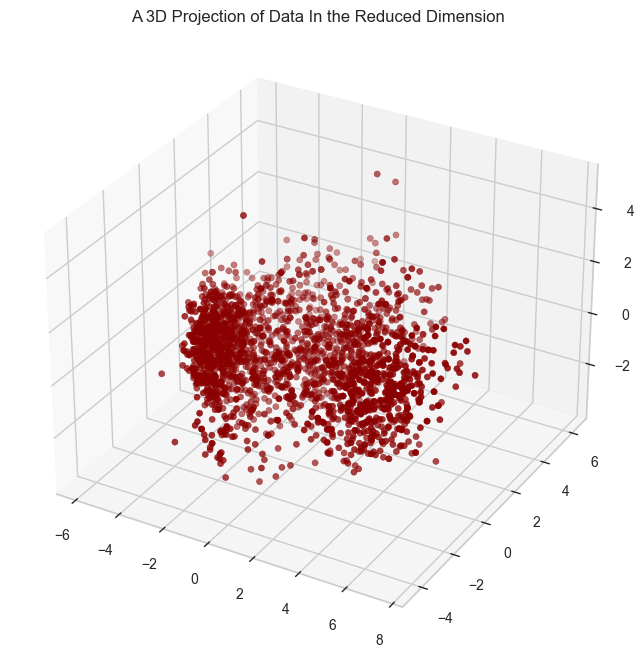

In [58]:
x = data_PCA['col1']
y = data_PCA['col2']
z = data_PCA['col3']

fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z, c='darkred', marker='o')
ax.set_title('A 3D Projection of Data In the Reduced Dimension')
plt.show()

Clustring

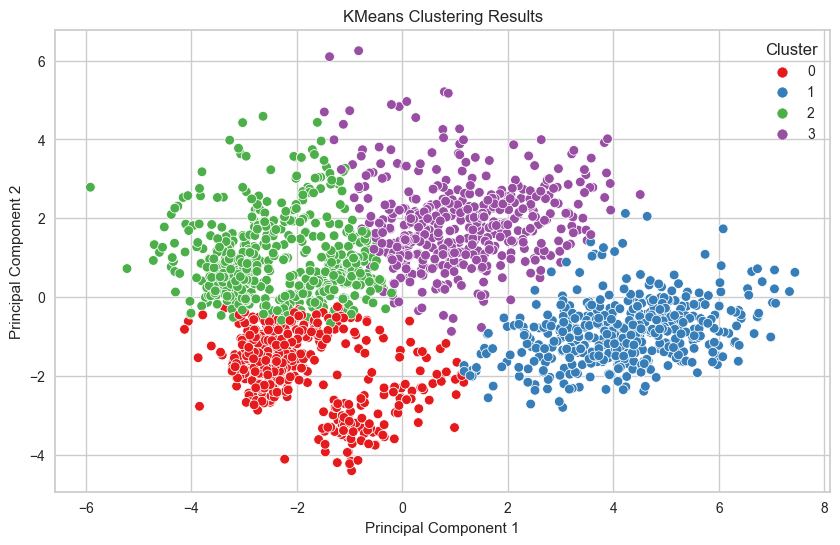

In [59]:
# Initialize the KMeans model
kmeans = KMeans(n_clusters=4, random_state=42)  # Adjust the number of clusters as needed

# Fit the model and predict clusters
yhat_kmeans = kmeans.fit_predict(data_PCA)

# Add the cluster labels to your DataFrame
data_PCA['Clusters'] = yhat_kmeans
data['Clusters'] = yhat_kmeans
data_old['Clusters'] = yhat_kmeans

plt.figure(figsize=(10, 6))

# Scatter plot for each cluster
sns.scatterplot(
    x=data_PCA.iloc[:, 0], y=data_PCA.iloc[:, 1],
    hue=data_PCA['Clusters'],
    palette='Set1',  # Use a color palette
    legend='full'
)

# Adding title and labels
plt.title('KMeans Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


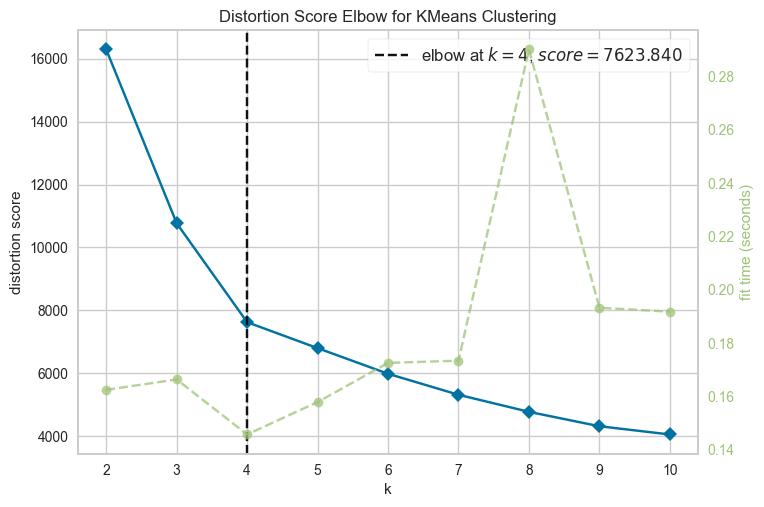

In [60]:
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(data_PCA)
Elbow_M.show();

       col1      col2      col3  Clusters
0  4.908732 -0.537851  0.449277         3
1 -2.865084  0.131295 -0.983883         1
2  2.597497 -0.780279 -0.043248         3
3 -2.650425 -1.456923  1.059099         2
4 -0.600206  0.438487  0.989088         1
   Education    Income   Kidhome  Teenhome   Recency  MntWines  MntFruits  \
0  -0.411675  0.287105 -0.822754 -0.929699  0.310353  0.977660   1.552041   
1  -0.411675 -0.260882  1.040021  0.908097 -0.380813 -0.872618  -0.637461   
2  -0.411675  0.913196 -0.822754 -0.929699 -0.795514  0.357935   0.570540   
3  -0.411675 -1.176114  1.040021 -0.929699 -0.795514 -0.872618  -0.561961   
4   1.123949  0.294307  1.040021 -0.929699  1.554453 -0.392257   0.419540   

   MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  \
0         1.690293         2.453472          1.483713      0.852576   
1        -0.718230        -0.651004         -0.634019     -0.733642   
2        -0.178542         1.339513         -0.147184     -0.037254   
3

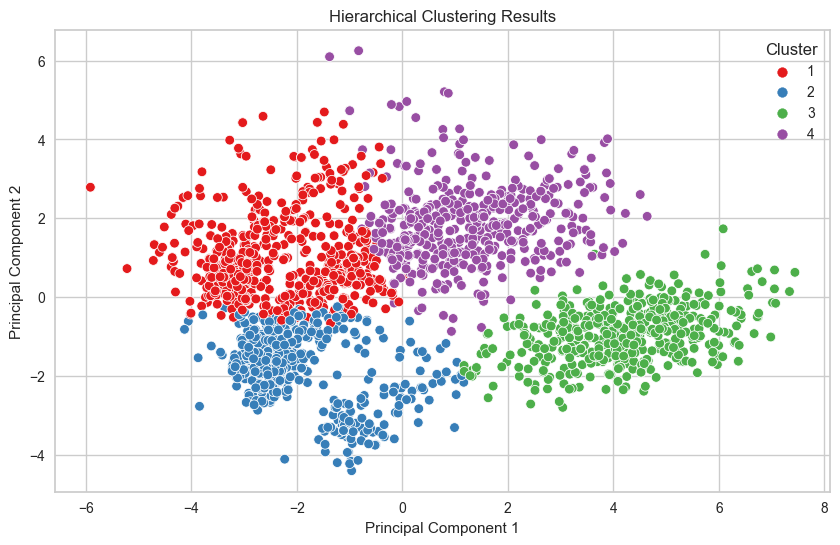

In [61]:
Z = linkage(data_PCA, method='ward')

yhat_HC = fcluster(Z, t=4, criterion='maxclust')

data_PCA['Clusters'] = yhat_HC
data['Clusters'] = yhat_HC
data_old['Clusters'] = yhat_HC

print(data_PCA.head())
print(data.head())
print(data_old.head())


plt.figure(figsize=(10, 6))

sns.scatterplot(
    x=data_PCA.iloc[:, 0], y=data_PCA.iloc[:, 1],
    hue=data_PCA['Clusters'],
    palette='Set1',  # Use a color palette
    legend='full'
)

plt.title('Hierarchical Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


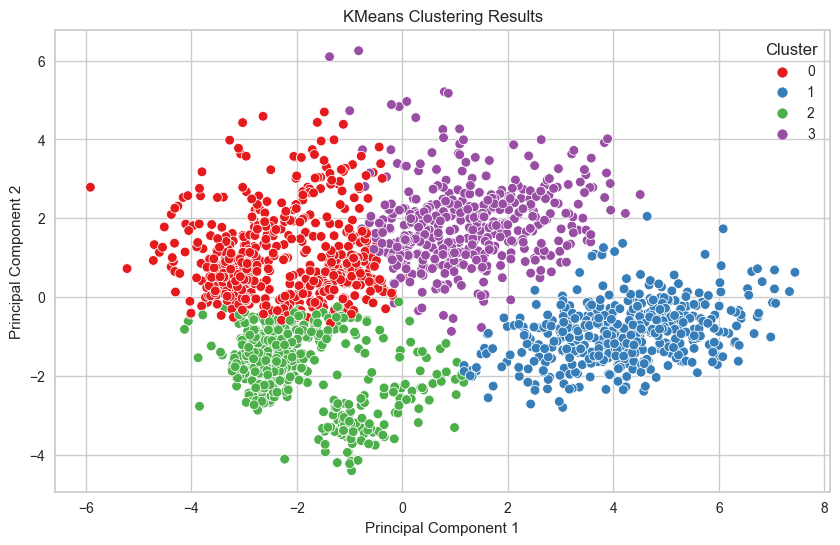

In [62]:
# Initialize the KMeans model
kmeans = KMeans(n_clusters=4, random_state=42)  # Adjust the number of clusters as needed

# Fit the model and predict clusters
yhat_kmeans = kmeans.fit_predict(data_PCA)

data_PCA['Clusters'] = yhat_kmeans
data['Clusters'] = yhat_kmeans
data_old['Clusters'] = yhat_kmeans

plt.figure(figsize=(10, 6))

sns.scatterplot(
    x=data_PCA.iloc[:, 0], y=data_PCA.iloc[:, 1],
    hue=data_PCA['Clusters'],
    palette='Set1',  # Use a color palette
    legend='full'
)

plt.title('KMeans Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


In [63]:
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(data_PCA)
data_PCA['Clusters'] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data['Clusters'] = yhat_AC
data_old['Clusters'] = yhat_AC

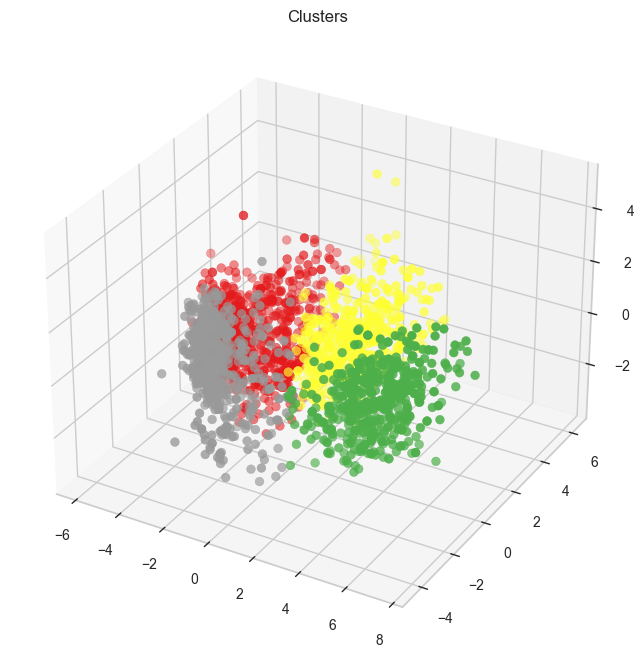

In [64]:
fig = plt.figure(figsize=(13,8))
ax = plt.subplot(111, projection='3d', label='bla')
ax.scatter(x, y, z, s=40, c=data_PCA['Clusters'], marker='o', cmap='Set1_r')
ax.set_title('Clusters')
plt.show()

Clustring Analysis

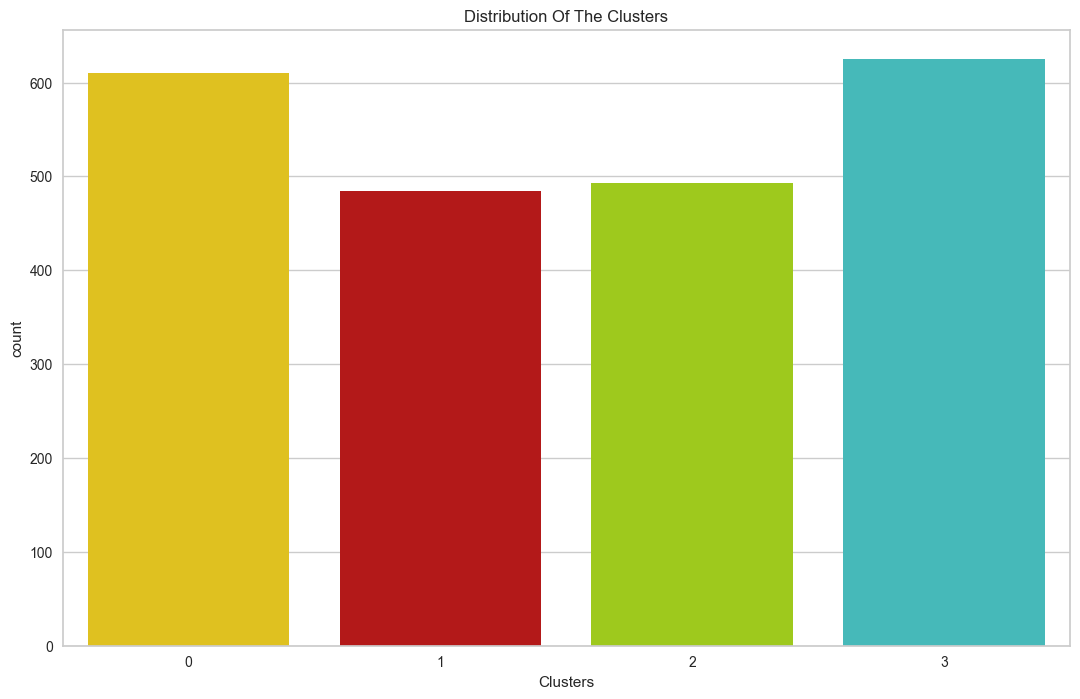

In [65]:
pal = ['gold','#cc0000', '#ace600','#33cccc']
plt.figure(figsize=(13,8))
pl = sns.countplot(x=data['Clusters'], palette= pal)
pl.set_title('Distribution Of The Clusters')
plt.show()

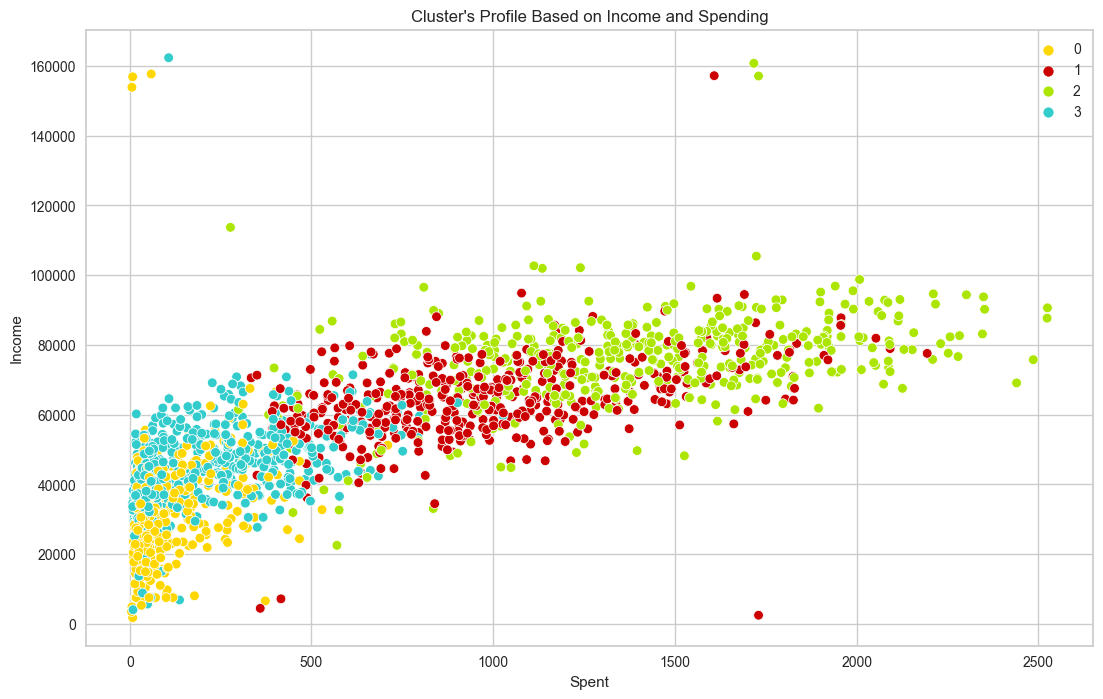

In [66]:
plt.figure(figsize=(13,8))
pl = sns.scatterplot(data=data_old, x=data_old['Spent'], y=data_old['Income'], hue=data_old['Clusters'], palette= pal)
pl.set_title("Cluster's Profile Based on Income and Spending")
plt.legend();

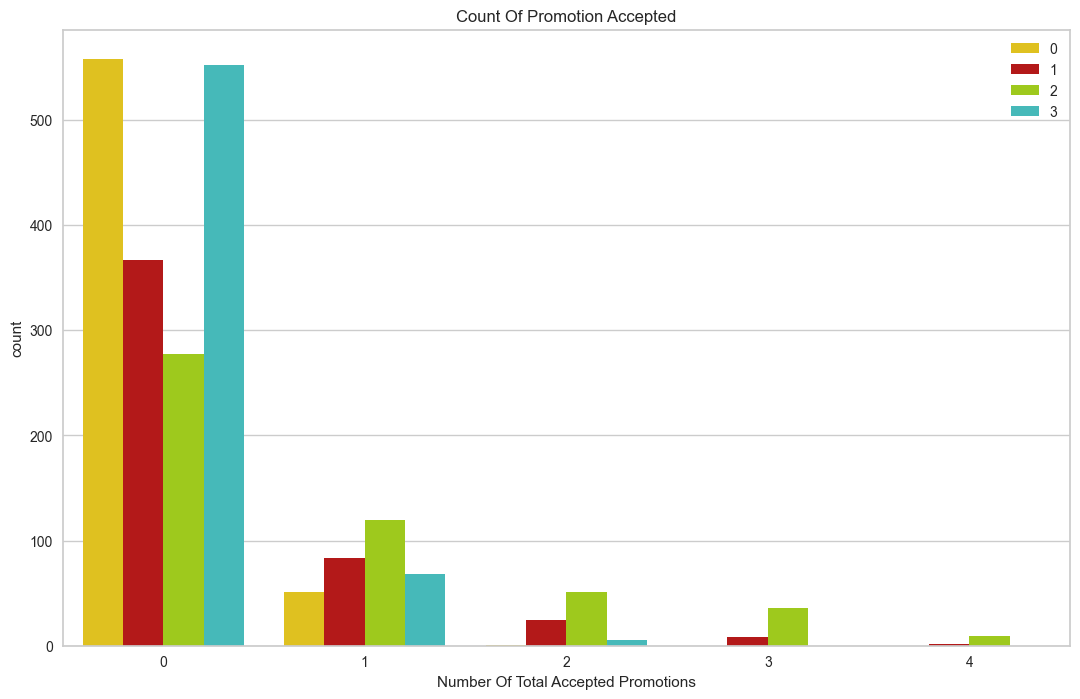

In [67]:
data_old['Total_Promos'] = data_old['AcceptedCmp1']+ data_old['AcceptedCmp2']+ data_old['AcceptedCmp3']+ data_old['AcceptedCmp4']+ data_old['AcceptedCmp5']

plt.figure(figsize=(13,8))
pl = sns.countplot(x=data_old['Total_Promos'], hue=data_old['Clusters'], palette= pal)
pl.set_title('Count Of Promotion Accepted')
pl.set_xlabel('Number Of Total Accepted Promotions')
plt.legend(loc='upper right')
plt.show();

<Figure size 1300x800 with 0 Axes>

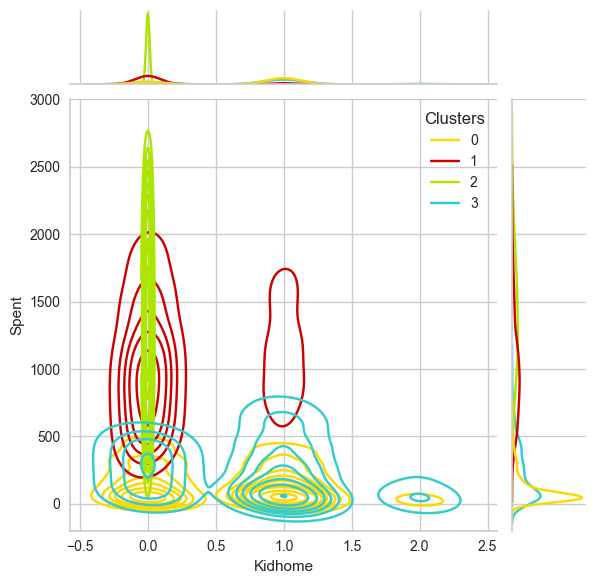

<Figure size 1300x800 with 0 Axes>

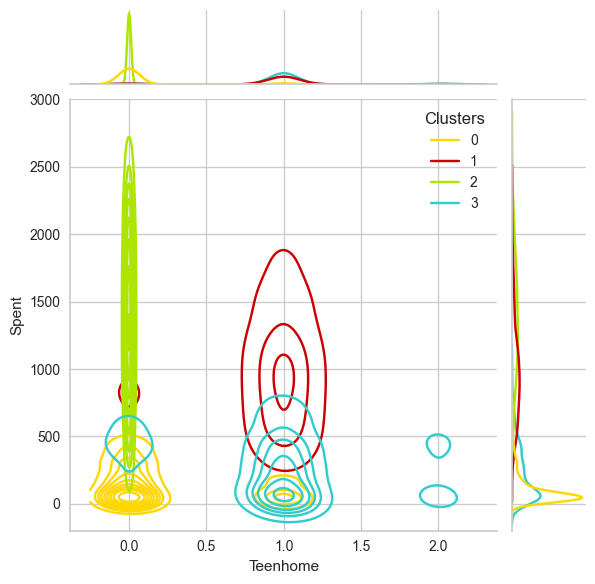

<Figure size 1300x800 with 0 Axes>

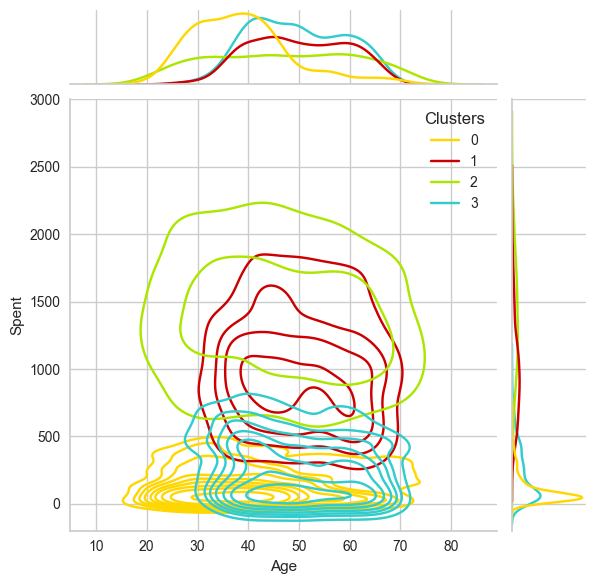

<Figure size 1300x800 with 0 Axes>

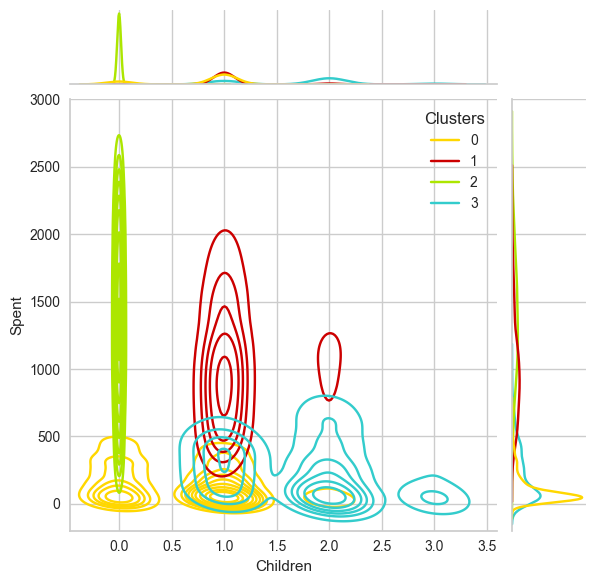

<Figure size 1300x800 with 0 Axes>

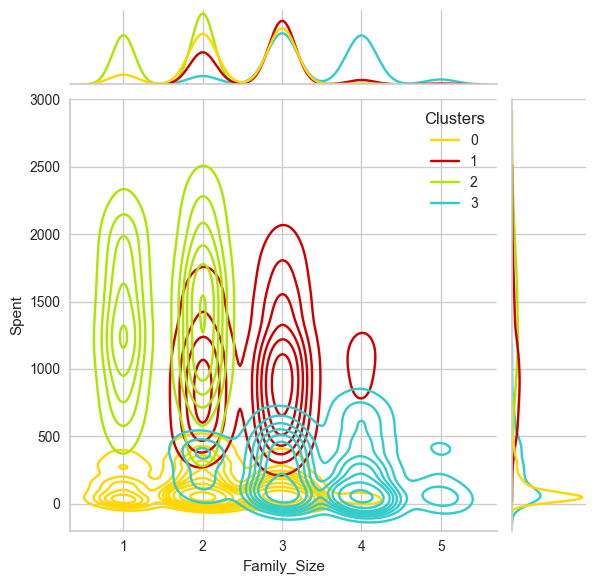

<Figure size 1300x800 with 0 Axes>

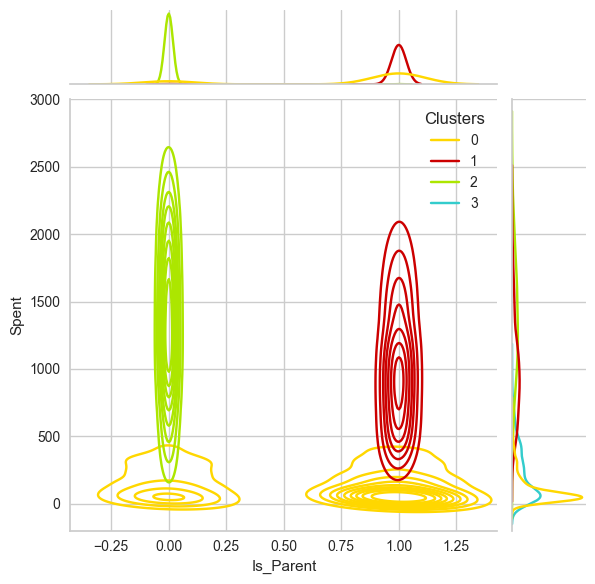

<Figure size 1300x800 with 0 Axes>

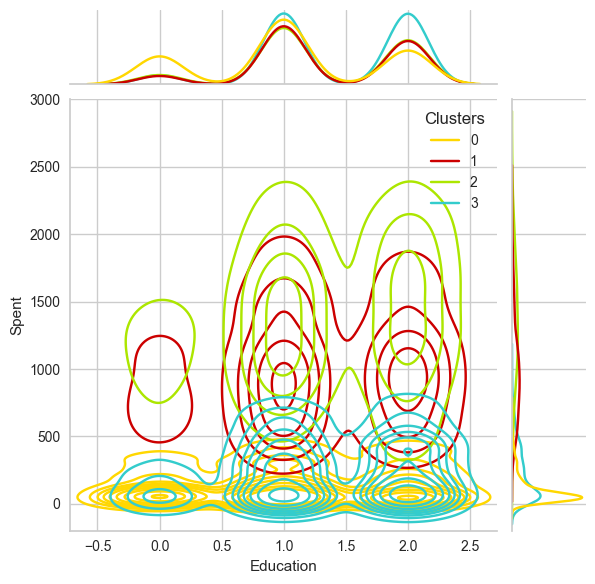

<Figure size 1300x800 with 0 Axes>

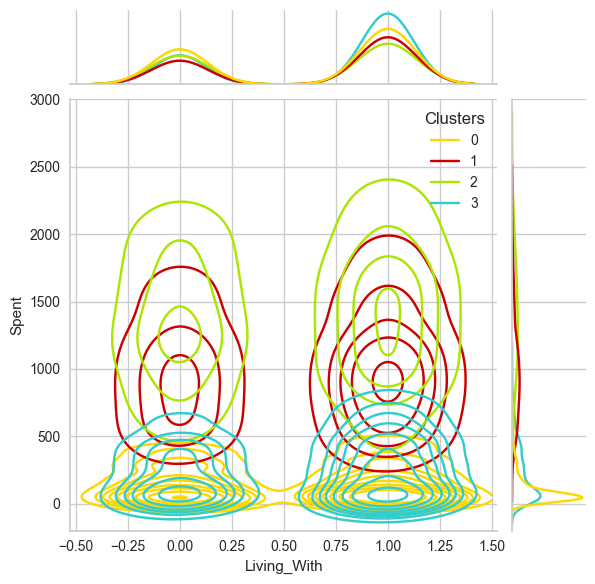

In [68]:
Personal = ['Kidhome', 'Teenhome', 'Age', 'Children', 'Family_Size', 'Is_Parent', 'Education', 'Living_With']

for i in Personal:
    plt.figure(figsize=(13,8))
    sns.jointplot(x=data_old[i], y=data_old['Spent'], hue=data_old['Clusters'], kind='kde', palette=pal);

**About Cluster 0:**
* The majority of these people are parents
* At max have 3 members in the family
* They majorly have one kid and typically not tennagers
* Relatively younger

**About Cluster 1:**
* Definitely a parent
* At max have 4 members in the family and at least 2
* Most have a teeanger in home
* Single parents are a subset of this group
* Relatively older

**About Cluster 2:**
* Definitely not a parent
* At max are only 2 members in the family.
* A slight majority of couples over single people
* Span all ages
* high income and high spending

**About Cluster 3:**
* Definitely a parent
* At max have 5 members in the family and at least 2
* Majority of them have a teenager at home
* Relatively older